<a href="https://colab.research.google.com/github/DayaAlex/CV-Person-Re-identification/blob/main/Siamese_Network_on_Pytorch_for_Person_Re_identifictationusing_Market_1501_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=33fb11fa498dabf036659fa5bf27482b321790973ba3cc32ea7dd4155e6a5e0a
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=865347349518666e32116d8f9f052f4a89443e34b27500591cff43fe975ae42b
  Stored in directory: /root/.cache/pip/w

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [ ]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 18.78 MiB/s, done.


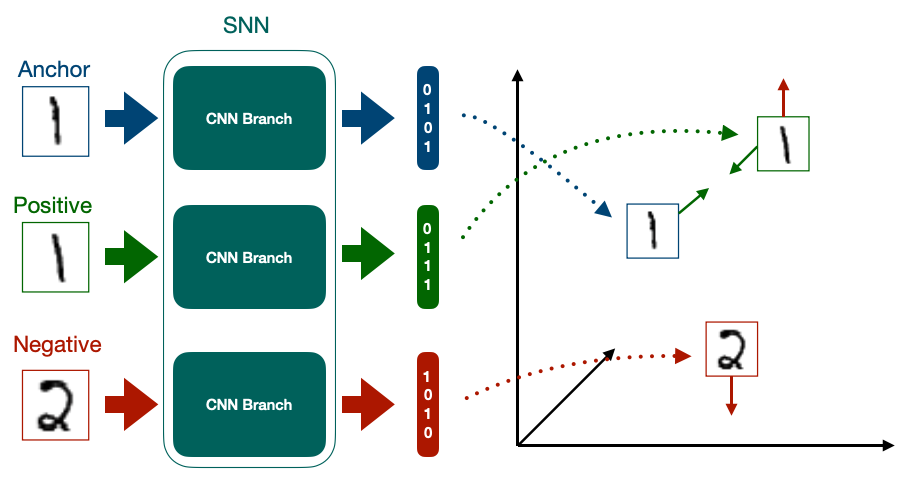

# Imports

In [ ]:
import sys 
sys.path.append('/content/Person-Re-Id-Dataset')

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import timm

import torch.nn.functional as F 
from torch import nn 
from torch.utils.data import Dataset, DataLoader 

from skimage import io
from sklearn.model_selection import train_test_split 

from tqdm import tqdm 

# Configurations

In [ ]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE ='cuda'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [ ]:
row = df.iloc[11]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

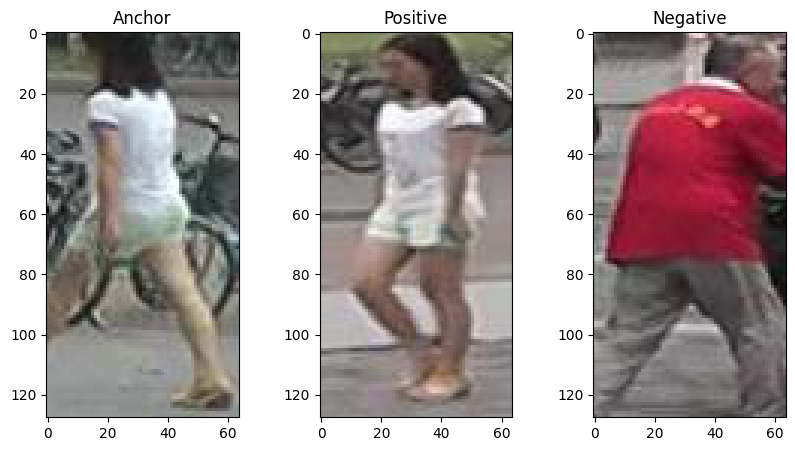

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)


ax2.set_title("Positive")
ax2.imshow(P_img)


ax3.set_title("Negative")
ax3.imshow(N_img)

In [ ]:
train_df, valid_df =train_test_split(df, test_size =0.20, random_state=42)

# Create APN Dataset 

In [ ]:
#anchor-positive-negative
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row =self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

#changeing from (h,w,c) to (c,h,w)
    A_img =torch.from_numpy(A_img).permute(2, 0, 1) /255.0 
    P_img =torch.from_numpy(P_img).permute(2, 0, 1) /255.0 
    N_img =torch.from_numpy(N_img).permute(2, 0, 1) /255.0 

    return A_img, P_img, N_img

In [ ]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"size of trainset : {len(trainset)}")#
print(f"size of validset :{len(validset)}")

size of trainset : 3200
size of validset :800


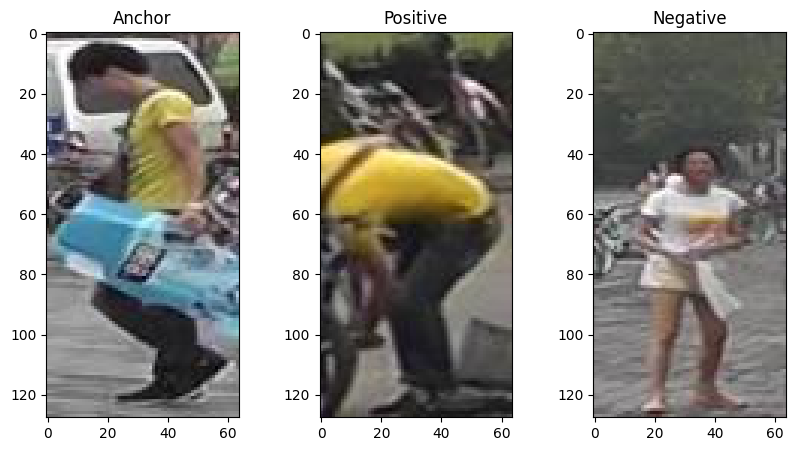

In [ ]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")#3200/32
print(f"No. of batches in validloader : {len(validloader)}")#800/32

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [ ]:
for A,P,N in trainloader:
  break;
    
print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model 

In [ ]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet =timm.create_model("efficientnet_b0", pretrained =True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):

    embedding = self.efficientnet(images)

    return embedding

In [ ]:
model = APN_Model()
model.to(DEVICE);


# Create Train and Eval function

In [ ]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()#ON Dropout and batchnorm
  total_loss =0.0

  for A,P,N in tqdm(dataloader):

    A, P, N =A.to(DEVICE),P.to(DEVICE), N.to(DEVICE)

    A_embs= model(A)
    P_embs= model(P)
    N_embs= model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()


  return total_loss / len(dataloader)


In [ ]:
def eval_fn(model, dataloader, criterion):

  model.train()#OFF Dropout and batchnorm
  total_loss =0.0

  with torch.no_grad():
      for A,P,N in tqdm(dataloader):

        A, P, N =A.to(DEVICE),P.to(DEVICE), N.to(DEVICE)

        A_embs= model(A)
        P_embs= model(P)
        N_embs= model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        total_loss += loss.item()


      return total_loss / len(dataloader)

In [ ]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

# Create Training Loop

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss =eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      best_valid_loss = valid_loss
      print("SAVED_WEIGHTS_SUCCESS")

  print(f"EPOCHS :{i+1} train_loss:{train_loss} valid_loss :{valid_loss}")


100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :1 train_loss:0.6218585833907128 valid_loss :0.4050523579120636


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :2 train_loss:0.29600202664732933 valid_loss :0.3352698040008545


100%|██████████| 25/25 [00:02<00:00,  9.62it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :3 train_loss:0.18726350903511046 valid_loss :0.20272870481014252


100%|██████████| 25/25 [00:02<00:00,  9.57it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :4 train_loss:0.08456584483385086 valid_loss :0.1587057489156723


100%|██████████| 25/25 [00:02<00:00,  8.88it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :5 train_loss:0.045478186085820195 valid_loss :0.15706674873828888


100%|██████████| 25/25 [00:03<00:00,  7.63it/s]


EPOCHS :6 train_loss:0.056293648481369016 valid_loss :0.20048737406730652


100%|██████████| 25/25 [00:02<00:00,  9.49it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :7 train_loss:0.06766319081187248 valid_loss :0.15465983748435974


100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :8 train_loss:0.05029273554682732 valid_loss :0.1463732522726059


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


EPOCHS :9 train_loss:0.04887527599930763 valid_loss :0.1565224474668503


100%|██████████| 25/25 [00:03<00:00,  7.96it/s]


EPOCHS :10 train_loss:0.04253637671470642 valid_loss :0.14795648723840713


100%|██████████| 25/25 [00:04<00:00,  5.34it/s]


EPOCHS :11 train_loss:0.059031442403793336 valid_loss :0.15221763491630555


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


EPOCHS :12 train_loss:0.055893113911151884 valid_loss :0.15270727574825288


100%|██████████| 25/25 [00:02<00:00,  8.51it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS :13 train_loss:0.034405863285064696 valid_loss :0.1335207611322403


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


EPOCHS :14 train_loss:0.044216593503952024 valid_loss :0.16096783995628358


100%|██████████| 25/25 [00:06<00:00,  3.67it/s]


EPOCHS :15 train_loss:0.055421210974454876 valid_loss :0.15573793649673462


# Get Anchor Embeddings

In [ ]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr= np.array(anc_img_names)
    encodings =[]

    model.eval()
    with torch.no_grad():
      for i in tqdm(anc_img_names_arr):
            A= io.imread(DATA_DIR +i)
            A= torch.from_numpy(A).permute(2,0,1) /255
            A=A.to(DEVICE)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

      encodings = np.array(encodings)
      encodings = pd.DataFrame(encodings)
      df_enc = pd.concat([anc_img_names, encodings], axis =1)

      return df_enc



In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:53<00:00, 74.46it/s]


In [ ]:
df_enc.to_csv('database.csv', index =False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,1.119972,-0.336237,0.888101,0.840234,1.441630,0.847399,-0.745965,0.089599,-0.728112,...,0.853659,-0.211393,0.351829,0.190187,0.978596,-0.376098,0.423617,0.497228,0.271558,0.632394
1,1420_c3s3_061978_03.jpg,0.887176,0.190565,0.093503,0.819319,0.770724,0.354480,-0.599354,0.466612,-0.387615,...,1.464228,-0.308621,0.521589,0.651497,-0.102095,0.146025,-0.202382,0.326337,0.385501,0.524396
2,1420_c5s3_062565_05.jpg,1.106388,-0.150277,0.591966,0.625803,1.289977,0.577915,-0.593279,-0.044092,-0.645845,...,0.775916,-0.324342,0.334509,0.125887,0.588987,-0.270623,0.117937,0.439138,0.128936,0.534254
3,1420_c6s3_085592_04.jpg,0.882278,-0.193837,0.904852,0.584275,1.354838,0.341679,-0.980568,-0.220289,-0.492830,...,0.351056,-0.299459,0.132637,0.405851,1.000404,-0.465552,0.556424,0.455290,0.051268,0.467330
4,0663_c5s3_085987_03.jpg,-0.423158,0.385623,0.291645,-0.196962,-0.778133,-1.076287,0.251332,0.258020,0.358794,...,-1.143580,-0.577798,0.083382,0.422876,0.320163,-0.535098,-0.060670,-0.368614,-0.185268,0.076063


# Inference

In [ ]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [ ]:
idx = 1
img_name =df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR +img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()


In [ ]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [ ]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)

In [ ]:
closest_idx = np.argsort(distance)

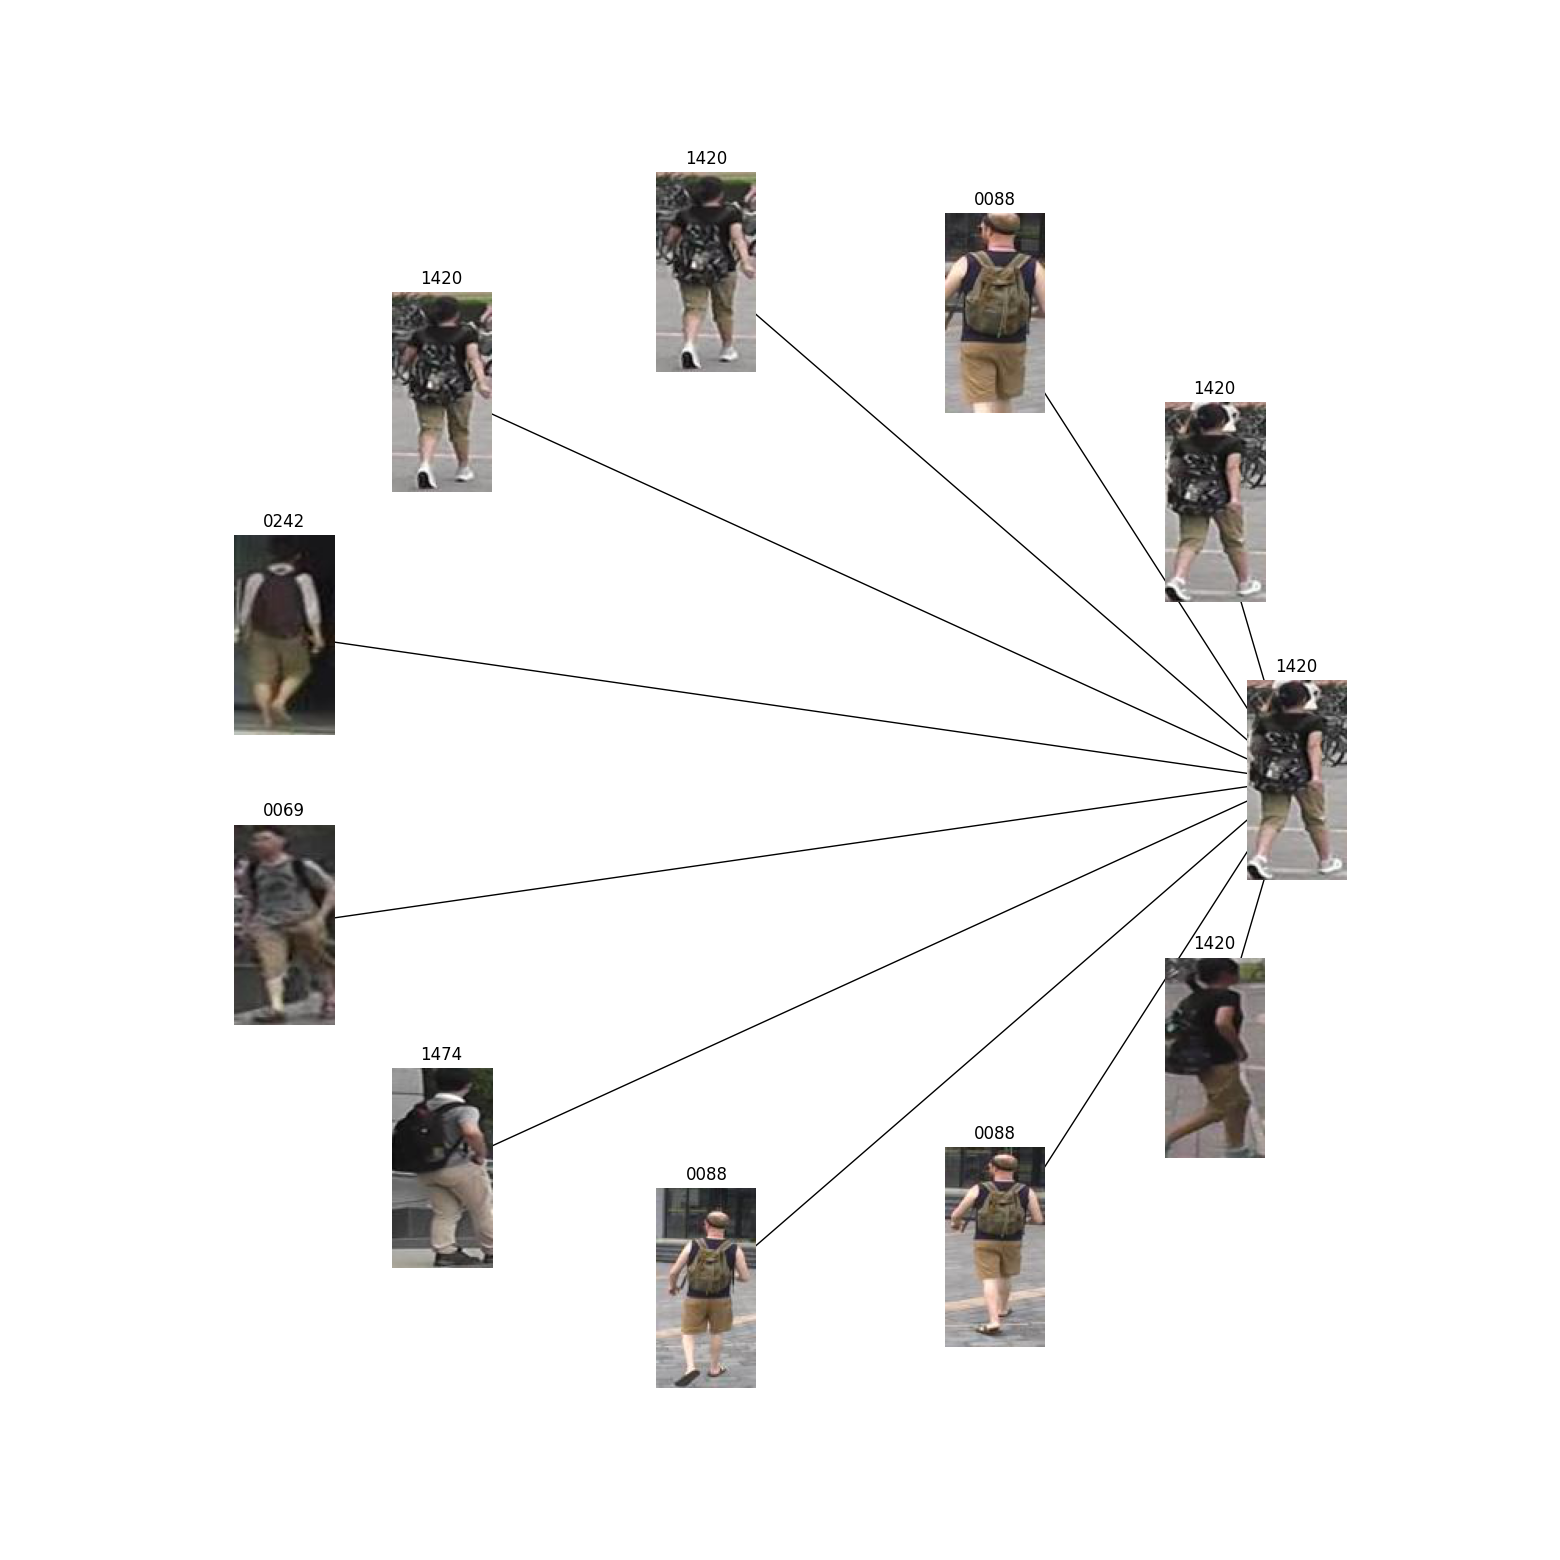

In [ ]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);